# ARIMA Models (Core)
- *David Atkins*

### Imports / Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

import statsmodels.tsa.api as tsa
import itertools

plt.rcParams['figure.figsize']=(12,3)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

### Import / Prepare Data

In [6]:
df = pd.read_csv('data\WMT.csv')
df.head()

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')
df = df.asfreq('B')
df.head(3)

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402


In [8]:
df.isna().sum()

Adj Close    195
dtype: int64

In [9]:
# Backfill nulls
df = df.ffill()
df.isna().sum()

Adj Close    0
dtype: int64

In [10]:
# Using ADF to evaluate for stationarity
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,2.45764,32,5446,0.999035,0.05,False


In [11]:
# evaluating once-differenced data
get_adfuller_results(df.diff().dropna())

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-13.911803,31,5446,0.0,0.05,True


In [12]:
# checking order
ndiffs(df)

2

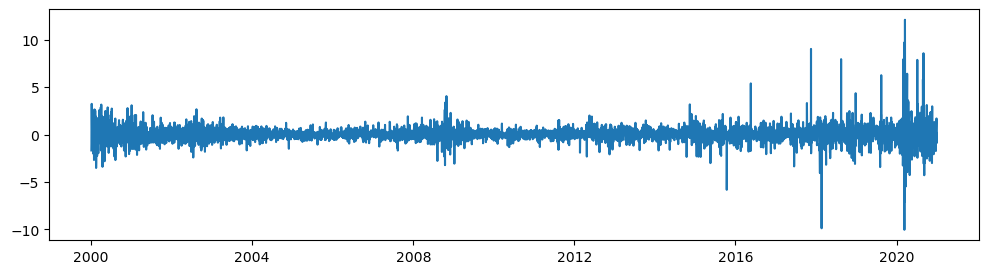

In [13]:
plt.plot(df.diff());

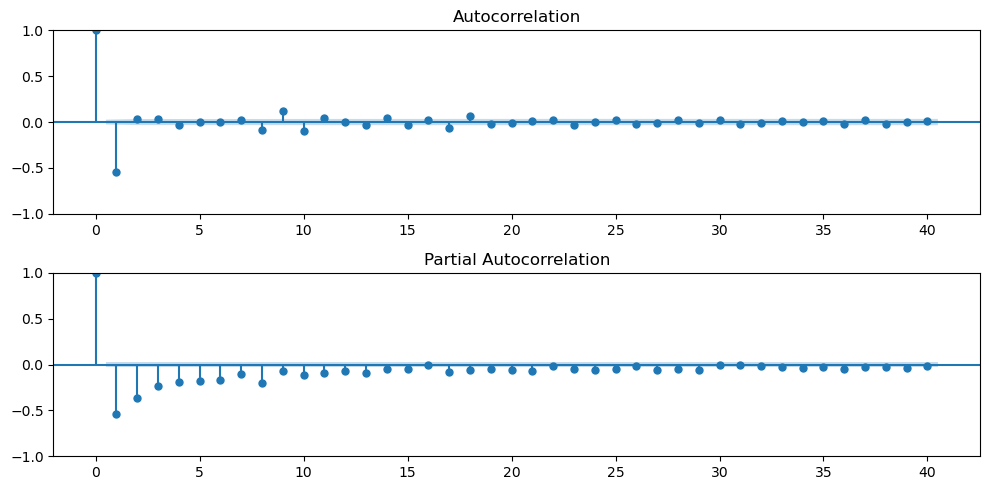

In [14]:
df_diff2 =df.diff().diff().dropna()
plot_acf_pacf(df_diff2);

- Manual Differencing and ndiff have different results, 1 and 2. 
- PACF has a gradual decrease
- There is a sharp drop after lag 1 on the ACF
- I will likely use a MA(1) model

### Train/Test Split

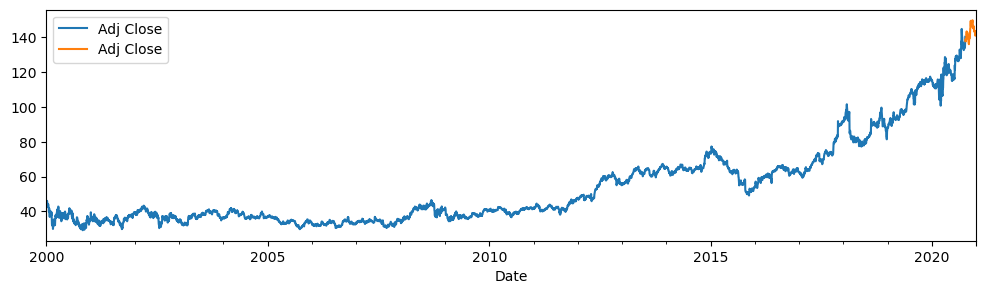

In [15]:
n_test_lags = 5*13

# modeling
train, test = train_test_split(df, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

### Manually Selected Model

In [16]:
# for 'd' am going with pmdarima's ndiffs per assignment suggestion
p = 0
d = 2
q =  1

# Define and fit
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.720
- MSE = 12.223
- RMSE = 3.496
- R^2 = 0.050
- MAPE = 1.88%


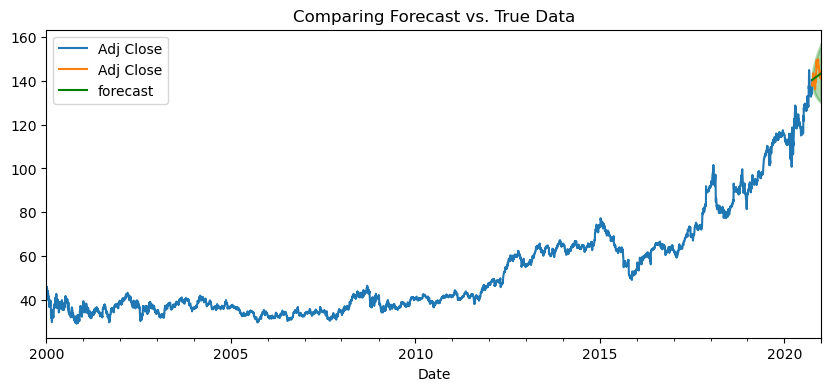

In [17]:
# summary of forecast
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

plot_forecast(train, test, forecast_df)

regression_metrics_ts(test, forecast_df['mean'])

In [18]:
# model summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5414
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -6682.931
Date:                Wed, 01 Nov 2023   AIC                          13369.863
Time:                        16:31:21   BIC                          13383.056
Sample:                    01-03-2000   HQIC                         13374.468
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.001  -1591.372      0.000      -1.000      -0.998
sigma2         0.6911      0.003    220.360      0.000       0.685       0.697
===================================================================================
Ljung-Box (L1) (Q):                  50.45   Jarque-Bera (JB):            265912.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

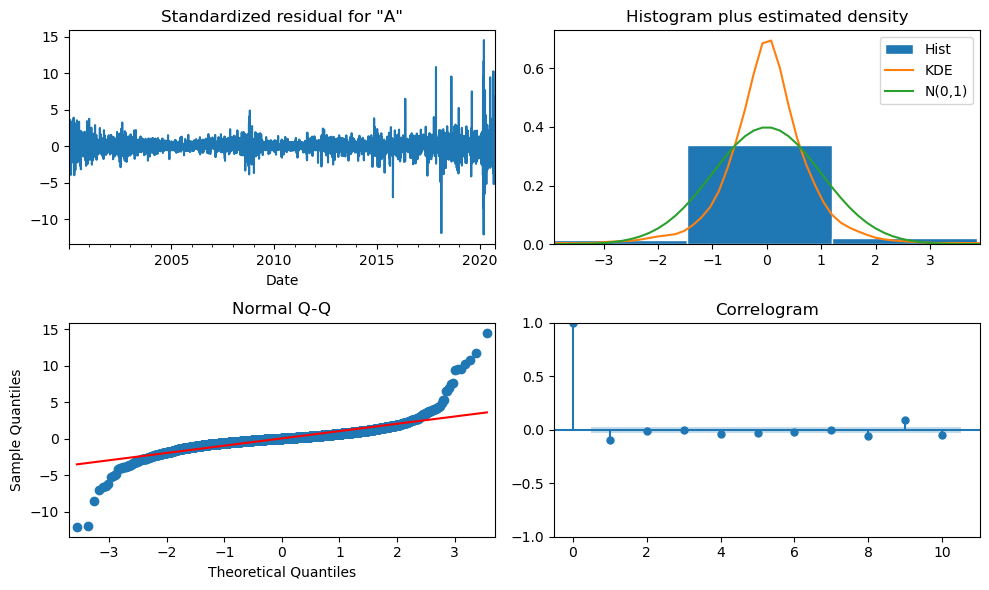

In [19]:
# diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

### Looping to Try Different Models

In [20]:
# Prepping for loop

p_values = range(0, 4)  
d_values = [2]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_test = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_test

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3)]

In [21]:
# starting aic
best_aic = float("inf")  

# baseline
best_pdq = (0,0,0)

# loop
for pdq in pdq_test:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 2, 0) 17599.851772490147
(0, 2, 1) 13369.862827971203
(0, 2, 2) 13319.34717936273
(0, 2, 3) 13320.344007562078
(1, 2, 0) 15737.030328258157
(1, 2, 1) 13321.06055250754
(1, 2, 2) 13373.86243188639
(1, 2, 3) 13315.575798310929
(2, 2, 0) 14997.34238660923
(2, 2, 1) 13320.896147838754
(2, 2, 2) 13324.380432853468
(2, 2, 3) 13317.600273043432
(3, 2, 0) 14685.11653954229
(3, 2, 1) 13322.560015703133
(3, 2, 2) 13317.176244422437
(3, 2, 3) 13296.009322818198
Best AIC: 13296.009322818198
Best pdq: (3, 2, 3)


In [25]:
# Building model with the best AIC
p = 3
d = 2
q = 3

best_pdq_model = tsa.ARIMA(train, order=(p,d,q)).fit()
best_pdq_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5414
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -6641.005
Date:                Wed, 01 Nov 2023   AIC                          13296.009
Time:                        16:34:08   BIC                          13342.184
Sample:                    01-03-2000   HQIC                         13312.128
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9954      0.013   -150.783      0.000      -2.021      -1.969
ar.L2         -1.1367      0.016    -69.617      0.000      -1.169      -1.105
ar.L3         -0.0973      0.006    -17.543      0.000      -0.108      -0.086
ma.L1          0.9047      0.012     73.563      0.000       0.881       0.929
ma.L2         -0.9555      0.003   -345.334      0.000      -0.961      -0.950
ma.L3         -0.9469      0.012    -78.422      0.000      -0.971      -0.923
sigma2         0.6806      0.004    182.642      0.000       0.673       0.688
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            214311.71
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               3.02   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

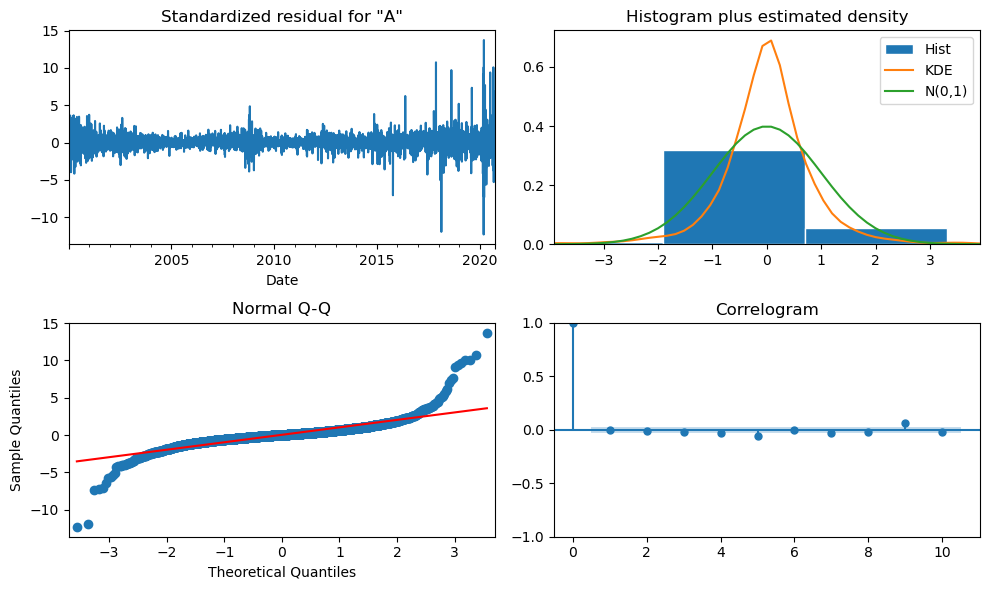

In [26]:
# Obtain diagnostic plots
fig = best_pdq_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.877
- MSE = 14.175
- RMSE = 3.765
- R^2 = -0.102
- MAPE = 1.98%


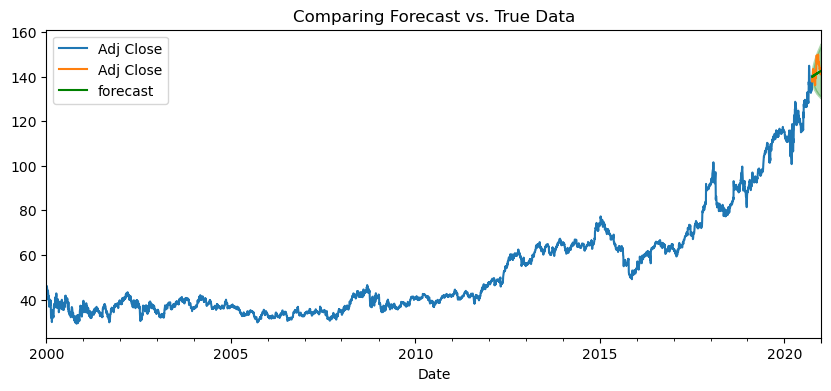

In [27]:
# Obtain summary of forecast as dataframe
forecast_df = best_pdq_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

### Comparing the models
| ARIMA | (0,2,1) | (3,2,3) |
|------|---------|---------|
| MAE  |   2.720 |   2.877 |
| MSE  |  12.220 |  14.175 |
| RMSE |   3.496 |   3.765 |
| R²   |   0.050 |  -0.102 |
| MAPE |  1.88% |  1.98%  |00%  |   |

- The Manual ARIMA(0,2,1) model performed best

##### Questions:
**How good was the model, according to the Mean Absolute Percentage Error?**
- 1.98% Mean Absolute Percentage Error

**How good was the  model in terms of how well the forecast seems to follow the test data, visually**
- The forecast seems to visually follow the test data trend line well
- See the following visualization)

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.877
- MSE = 14.175
- RMSE = 3.765
- R^2 = -0.102
- MAPE = 1.98%


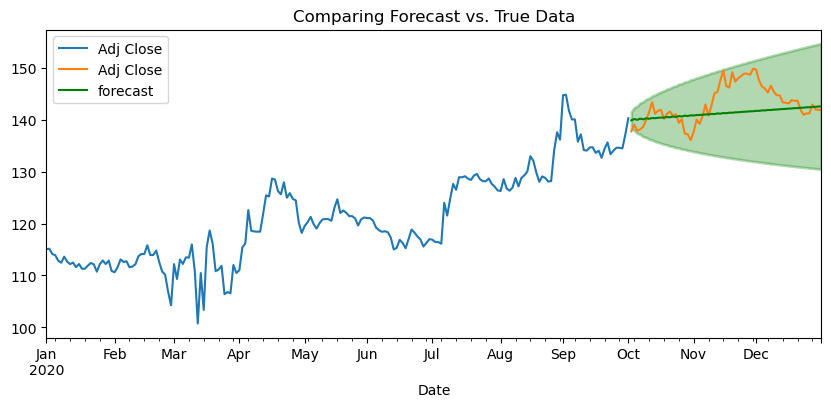

In [36]:
res = train[~(train.index < '2020-01-01')]
forecast_df = best_pdq_model.get_forecast(len(test)).summary_frame()
plot_forecast(res, test, forecast_df)
regression_metrics_ts(test, forecast_df['mean'])